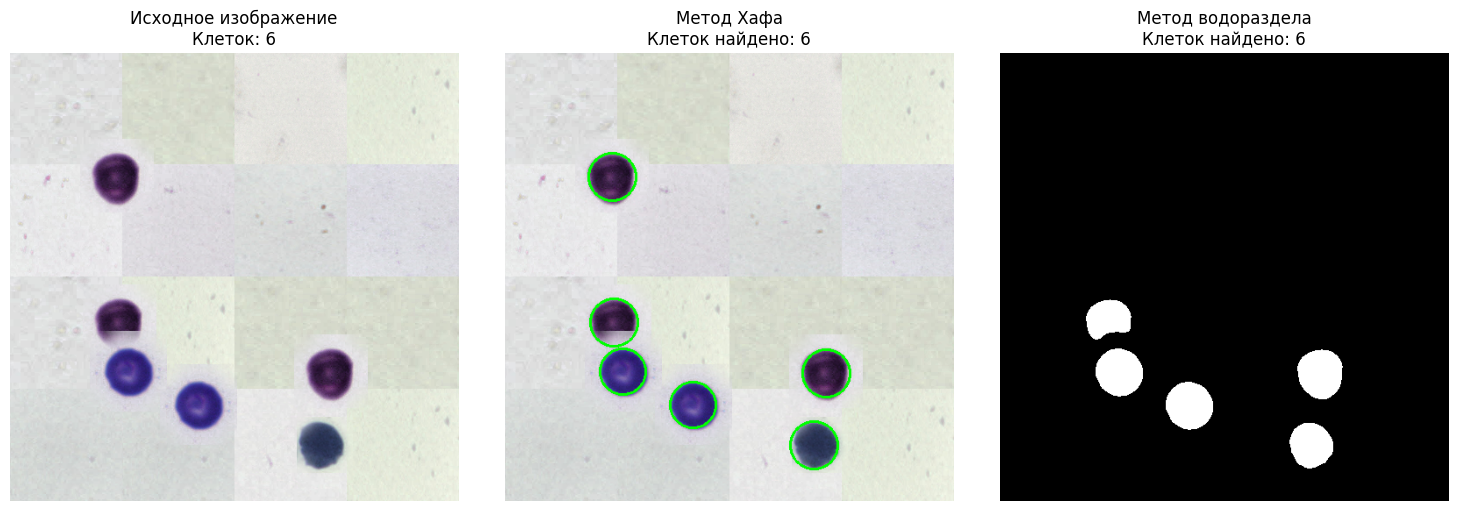

Изображение 1:
Реальное количество клеток: 6
Клеток найдено методом Хафа: 6
Клеток найдено методом водораздела: 6



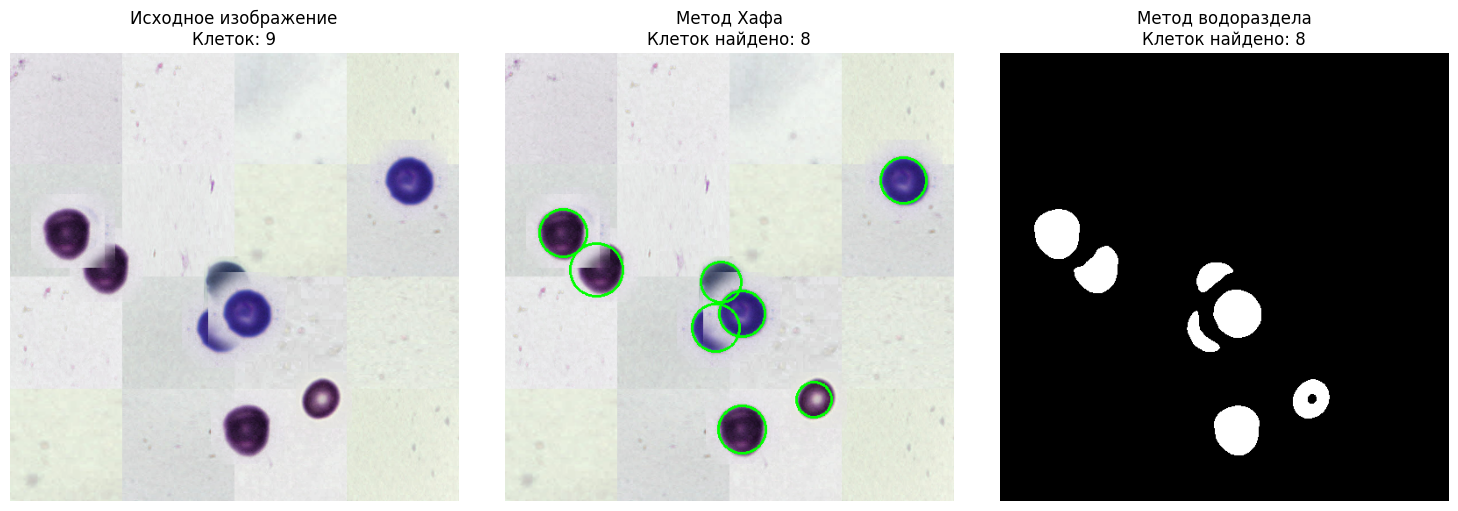

Изображение 2:
Реальное количество клеток: 9
Клеток найдено методом Хафа: 8
Клеток найдено методом водораздела: 8



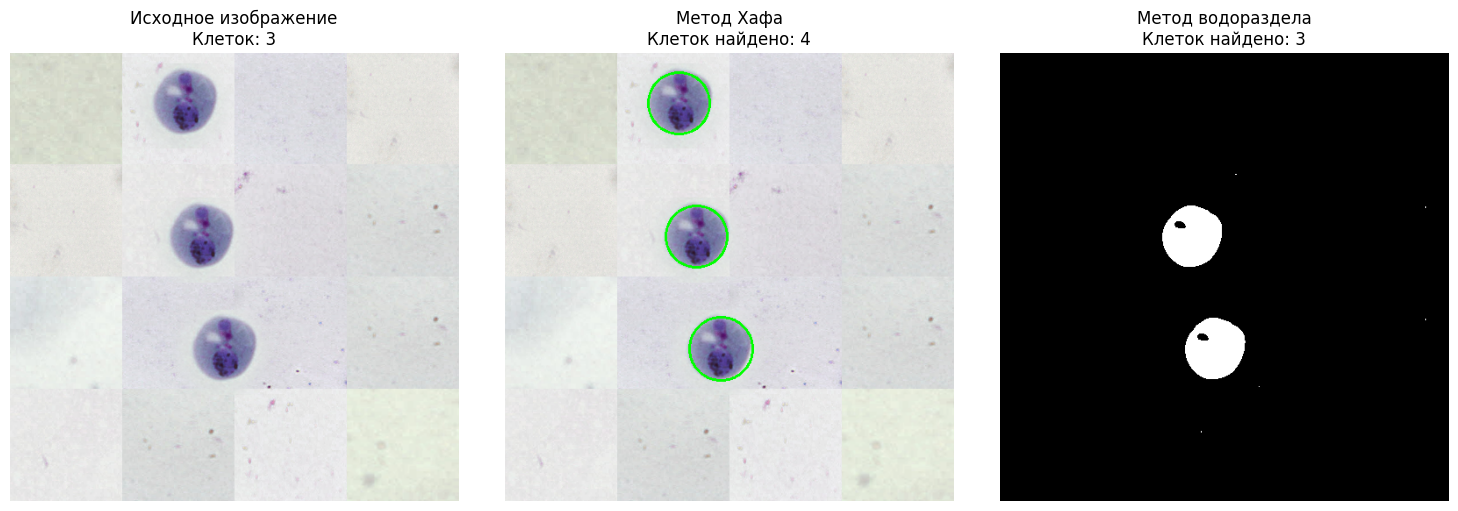

Изображение 3:
Реальное количество клеток: 3
Клеток найдено методом Хафа: 4
Клеток найдено методом водораздела: 3



In [44]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

def load_patches_from_folder(folder_path):
    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background_from_patches(background_patches, num_patches=8, output_size=(256, 256)):
    selected_patches = random.choices(background_patches, k=num_patches)
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
    patch_size = 128
    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            if selected_patches:
                patch = selected_patches.pop()
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = cv2.resize(patch, (patch_size, patch_size))
                try:
                    background[i:i+patch_size, j:j+patch_size] = patch
                except ValueError as e:
                    print(f"Ошибка при размещении патча: {e}")
                    continue
            else:
                break
    return background

def overlay_cells_on_background(background, cell_patches, num_cells=5):
    output = background.copy()
    for _ in range(num_cells):
        cell = random.choice(cell_patches)

        # уменьшим размер клетки в 2 раза
        cell = cv2.resize(cell, (cell.shape[1] // 2, cell.shape[0] // 2))

        x = random.randint(0, background.shape[0] - cell.shape[0])
        y = random.randint(0, background.shape[1] - cell.shape[1])

        mask = np.zeros((cell.shape[0], cell.shape[1], 3), dtype=np.uint8)
        radius = min(cell.shape[0], cell.shape[1]) // 2
        cv2.circle(mask, (cell.shape[1] // 2, cell.shape[0] // 2), radius, (255, 255, 255), -1)
        mask = cv2.GaussianBlur(mask, (51, 51), 0)
        mask = mask.astype(np.float32) / 255.0

        for c in range(3):
            output[x:x+cell.shape[0], y:y+cell.shape[1], c] = (
                output[x:x+cell.shape[0], y:y+cell.shape[1], c] * (1 - mask[:, :, c]) +
                cell[:, :, c] * mask[:, :, c]
            )
    return output

def hough_transform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=25, minRadius=10, maxRadius=50)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        return len(circles[0])
    return 0

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    distance = ndimage.distance_transform_edt(binary)
    coords = peak_local_max(distance, min_distance=20, labels=binary)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    labels = watershed(-distance, markers, mask=binary)
    return len(np.unique(labels)) - 1

patches_folder = '/content/patches'
background_folder = os.path.join(patches_folder, 'background')
cells_folder = os.path.join(patches_folder, 'cells')

background_patches = load_patches_from_folder(background_folder)
cell_patches = load_patches_from_folder(cells_folder)

# Генерация и обработка изображений
for i in range(3):
    num_patches_for_background = 16
    background = generate_background_from_patches(background_patches, num_patches=num_patches_for_background, output_size=(512, 512))
    num_cells = random.randint(3, 10)
    final_image = overlay_cells_on_background(background, cell_patches, num_cells=num_cells)

    output_filename = f'generated_image_{i+1}.png'
    cv2.imwrite(output_filename, final_image)

    hough_count = hough_transform(final_image)
    watershed_count = watershed_segmentation(final_image)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Исходное изображение\nКлеток: {num_cells}")
    axes[0].axis('off')

    # Метод Хафа
    hough_image = final_image.copy()
    gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 7)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                               param1=50, param2=25, minRadius=10, maxRadius=50)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            cv2.circle(hough_image, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
    axes[1].imshow(cv2.cvtColor(hough_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Метод Хафа\nКлеток найдено: {hough_count}")
    axes[1].axis('off')

    # Метод водораздела
    gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    distance = ndimage.distance_transform_edt(binary)
    coords = peak_local_max(distance, min_distance=20, labels=binary)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndimage.label(mask)
    labels = watershed(-distance, markers, mask=binary)
    labels_image = np.zeros_like(final_image, dtype=np.uint8)
    labels_image[labels > 1] = 255
    axes[2].imshow(labels_image, cmap='nipy_spectral')
    axes[2].set_title(f"Метод водораздела\nКлеток найдено: {watershed_count}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Изображение {i+1}:")
    print(f"Реальное количество клеток: {num_cells}")
    print(f"Клеток найдено методом Хафа: {hough_count}")
    print(f"Клеток найдено методом водораздела: {watershed_count}")
    print()